<a href="https://colab.research.google.com/github/sumankanukollu/EVA_4_Assignments/blob/S_10_LRFinder_Misclassified_Cifar10/EVA4_S11_fastAi_OCP_Suman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Set the drive location

In [2]:
import os,sys

os.chdir('/content/drive/My Drive/pytorch_Framework_suman')
homepath  = os.getcwd()
print('\n### Home Path is : {}'.format(homepath))
!ls
sys.path.append(os.path.join(homepath,'lib'))


### Home Path is : /content/drive/My Drive/pytorch_Framework_suman
25_misclassifiedGradCamImages.jpg
data
EVA-4-S10-Suman-Kanukollu-LRFinder_CIFAR_10.ipynb
EVA_4_S11_Praveen_Raghuvanshi_Main.ipynb
EVA4_S11_Suman.ipynb
EVA-4-S11-Suman-Kanukollu-CIFAR_10.ipynb
EVA-4-S9-Suman-Kanukollu-Main.ipynb
lib
metrics.png
misclassified.png
models
outputs
pytorch_OCP_EVA4_S11_Suman.ipynb
resnet18_cifar10_main.ipynb
sampleImages
utils


# Set device

In [3]:
import torch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
print(torch.cuda.is_available())

cuda
True


#  Prepare Dataset

In [0]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt

from lib.loadDataSet import dataSetFunctions

dsObj   =   dataSetFunctions()

In [5]:
# Data transforms (normalization & data augmentation)
from lib.cutout import Cutout
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor(), 
                         Cutout(n_holes=1, length=8),
                         tt.Normalize(*stats)])
test_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

(trainset,testset)    =   dsObj.dataSet(transform=(train_tfms,test_tfms),name='cifar10')


### Preparing dataset for the name : cifar10
Files already downloaded and verified
Files already downloaded and verified


In [6]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )

# Print one image from the train dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>
Image label is : frog


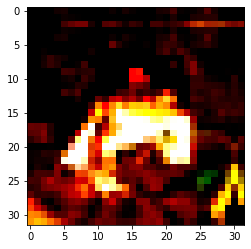

In [7]:
from matplotlib import pyplot as plt
def show_imgs(img,label):
    print(type(img))
    print('Image label is : {}'.format(trainset.classes[label]))
    plt.imshow(img.permute(1, 2, 0))

show_imgs(*trainset[0])

In [0]:
from torch.utils.data import DataLoader
batch_size = 512
# PyTorch data loaders
train_dl = DataLoader(trainset, batch_size, shuffle=True, 
                      num_workers=8, pin_memory=True)
valid_dl = DataLoader(testset, batch_size, shuffle=False, 
                      num_workers=8, pin_memory=True)

# Display Images from the Train Data Loader

In [0]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [0]:
def show_batch(dl,numOfImagesToDisplay=100,imgsPerRow=10):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(26, 26))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:numOfImagesToDisplay], imgsPerRow).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


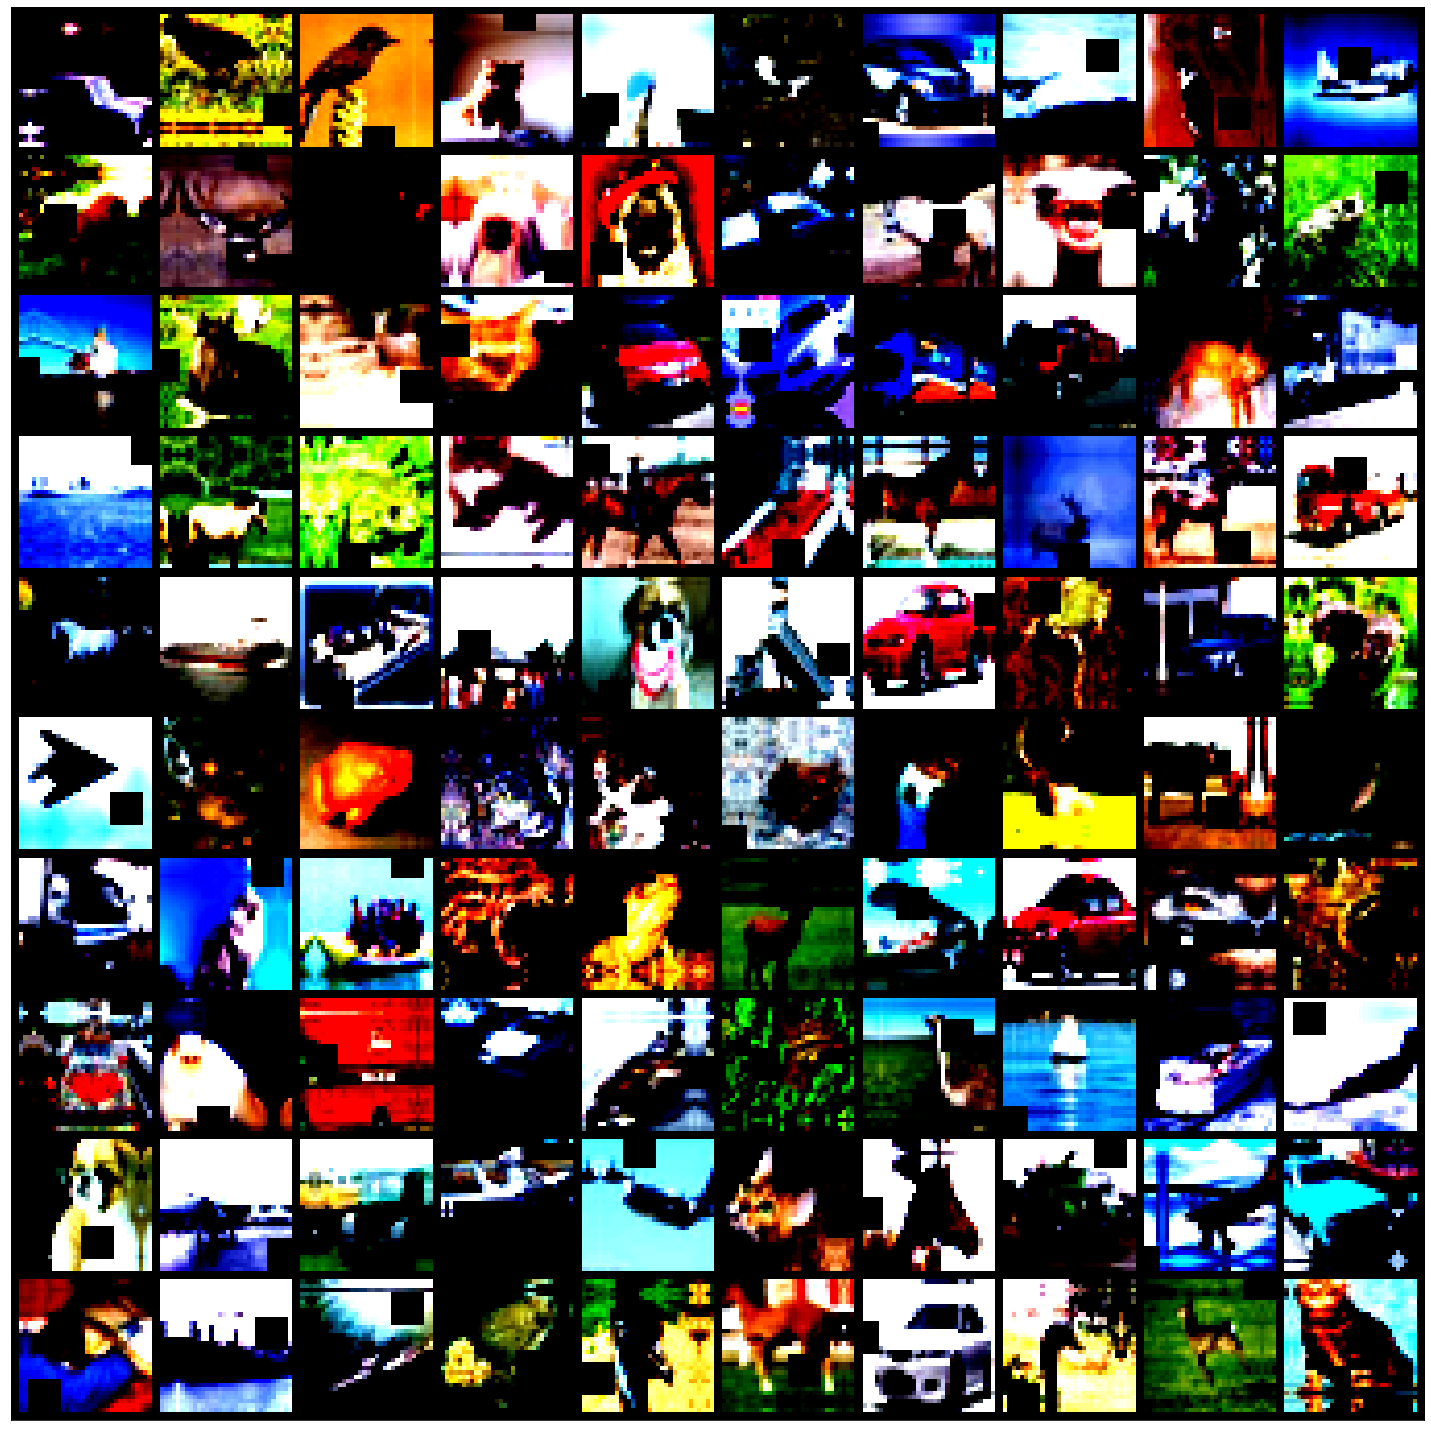

In [11]:
show_batch(train_dl)

# Import EVA-4 Session-11 Model


In [0]:
from models.resnet import *


In [13]:
from torchsummary import summary
model =s11Model().to(device)

summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

# Test the model what we have written

In [14]:
for images, labels in train_dl:
    images, labels = images.cuda(), labels.cuda()
    print('images.shape:', images.shape)
    #print('Length of images : {}'.format(len(images)))
    #print('Length of Labels : {}'.format(len(labels)))
    out = model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([512, 3, 32, 32])
out.shape: torch.Size([512, 10])


# Training the model - With One Cycle policy

[Source link](https://docs.fast.ai/callbacks.one_cycle.html#What-is-1cycle?)

In [0]:
from fastai.basic_data import DataBunch
from fastai.train import Learner
from fastai.metrics import accuracy

In [16]:
model.parameters()

<generator object Module.parameters at 0x7f9abcd388e0>

In [0]:
#data = DataBunch(train_dl, valid_dl)
#criterion = nn.CrossEntropyLoss()
#opt_func = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
import torch.optim as optim
from IPython.core.debugger import set_trace

opt_func = optim.SGD(params=model.parameters(), lr=0.1)

data = DataBunch.create(trainset, testset,bs=batch_size,path='./data')

learner = Learner(data=data, model=model.cuda(),opt_func=optim.SGD, loss_func=F.cross_entropy, metrics=[accuracy])
#learner.clip = 0.1


# Find optimum LR through LR finder test

- To use 1cycle policy we will need an optimum learning rate. 
- We can find this learning rate by using a learning rate finder which can be called by using lr_finder
- It will do a mock training by going over a large range of learning rates, then plot them against the losses.
- We will pick a value a bit before the minimum, where the loss still improves.

In [18]:
len(trainset)/batch_size

97.65625

for CIFAR10 train set is 50000, and we use batch size of 512
so number of iterations = 50000/512 = 97.65 = @100


In [19]:
# lr_find(learn:Learner, start_lr:Floats=1e-07, end_lr:Floats=10, num_it:int=100, stop_div:bool=True, wd:float=None)
learner.lr_find(start_lr = 1e-7,end_lr = 10,num_it=100,stop_div= True,wd=None)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.00E-03
Min loss divided by 10: 7.59E-04


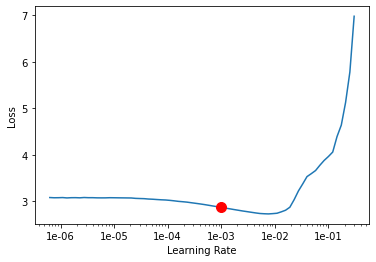

In [20]:
learner.recorder.plot(suggestion=True)

In [21]:
lrmin = learner.recorder.min_grad_lr
lrmax = lrmin*10
print('lrmin is : {}\nlrmax is : {}'.format(lrmin,lrmax))

lrmin is : 0.001
lrmax is : 0.01


Based on the above graph we can use below values : 
- LR min = 1/10 or 1/8 of LRmax  = 0.001202264434617413
- LR max = 0.001202264434617413 * 10 = 0.01202264434617413
- cycle  = 24
- momentum range = (0.95, 0.85)
- Iterations = 100
- Batch sz = 512
- step size = 5
- 



# one cycle scheduler

In [22]:
# OneCycleScheduler(learn:Learner, lr_max:float, moms:Floats=(0.95, 0.85), div_factor:float=25.0, pct_start:float=0.3, final_div:float=None, tot_epochs:int=None, start_epoch:int=None)
''' fit_one_cycle(learn:Learner, 
                  cyc_len:int, 
                  max_lr:Union[float, Collection[float], slice]=slice(None, 0.003, None), 
                  moms:Point=(0.95, 0.85), 
                  div_factor:float=25.0, 
                  pct_start:float=0.3, 
                  final_div:float=None, 
                  wd:float=None, 
                  callbacks:Optional[Collection[Callback]]=None, 
                  tot_epochs:int=None, 
                  start_epoch:int=None)

'''

' fit_one_cycle(learn:Learner, \n                  cyc_len:int, \n                  max_lr:Union[float, Collection[float], slice]=slice(None, 0.003, None), \n                  moms:Point=(0.95, 0.85), \n                  div_factor:float=25.0, \n                  pct_start:float=0.3, \n                  final_div:float=None, \n                  wd:float=None, \n                  callbacks:Optional[Collection[Callback]]=None, \n                  tot_epochs:int=None, \n                  start_epoch:int=None)\n\n'

In [23]:
#learner.fit_one_cycle(24, 1e-2, wd=1e-4)
#learner.fit_one_cycle(24, 1e-2)
learner.fit_one_cycle(cyc_len = 24, max_lr = lrmax, pct_start=(5.0/24.0),div_factor =10.0)

epoch,train_loss,valid_loss,accuracy,time
0,1.616716,1.349105,0.515900,00:29
1,1.249127,1.048585,0.625100,00:29
2,1.028834,1.071099,0.640100,00:29
3,0.863775,0.868626,0.716700,00:29
4,0.755845,0.760682,0.741700,00:29
5,0.665583,0.589453,0.798500,00:29
6,0.603375,0.640969,0.786900,00:29
7,0.546845,0.522585,0.828300,00:29
8,0.494590,0.501237,0.836000,00:29
9,0.441948,0.475688,0.842800,00:29


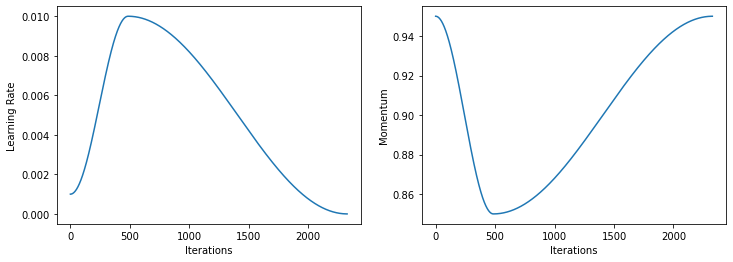

In [24]:
learner.recorder.plot_lr(show_moms=True)

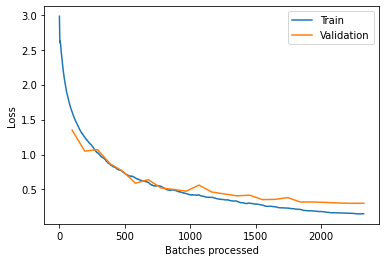

In [25]:
learner.recorder.plot_losses()

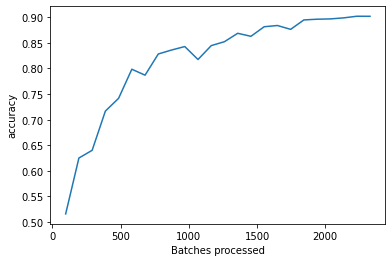

In [26]:
learner.recorder.plot_metrics()

In [27]:
learner.one_cycle_scheduler.phases

((485, <function fastai.callback.annealing_cos>),
 (1843, <function fastai.callback.annealing_cos>))

# Code to plot Multiple Cycles 

In [0]:
#####
import numpy as np
import matplotlib.pyplot as plt
def plotCyclicLR(total_iterations,min_lr,max_lr,step_size):
  l_rate=[]
  for iteration in range(total_iterations):
    cycle = np.floor(1 + iteration / (2 * step_size))
    x = np.abs((iteration / step_size) - 2 * cycle + 1)
    lr = min_lr + ((max_lr - min_lr) * (1 - x))
    l_rate.append(lr)
  plt.plot(list(range(total_iterations)),l_rate)

cycle = 2*stepsize


no if cycles = total-iterations/cycle


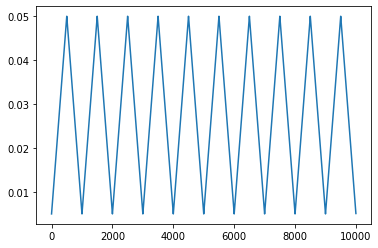

In [31]:
plotCyclicLR(total_iterations=10000, min_lr=0.005, max_lr=0.05, step_size=500)